In [1]:
import torch
from torch import nn

import model_predict

In [2]:
series, scaler = model_predict.read_data_series(scale=True, file_index=4)

时间序列不连贯，缺失的月份： ['2018-02', '2018-12', '2019-02', '2019-12', '2020-11', '2020-12', '2021-01', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02']
即将填充缺失的月份
月份平均：
月份
1     541.336000
2     399.416000
3     638.322000
4     612.754909
5     653.405818
6     728.001455
7     610.260364
8     718.357818
9     753.433455
10    658.463200
11    585.294667
12    288.616571
Name: 销量（箱）, dtype: float64


In [3]:
# 4.1 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out

    def init_weights(self):
        # 遍历 LSTM 层的参数，对参数进行初始化
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.1)  # 使用正态分布初始化权重
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # 将偏置项初始化为零
                
model_parameters = {
    "input_size": 3, "hidden_size": 24, "num_layers": 1, "output_size": 1
}

In [4]:
model_predict.train_rnn_model(LSTMModel, model_parameters, series,
                              test_shuffle=True, test_size=24, epochs=1000)

训练 LSTMModel 模型
结果保存到： LSTMModel_best.pth
Epoch [50/1000], Learn Rate: 1.0000e-03, Training Loss: 0.5994, Validation Loss: 0.4211
Epoch [100/1000], Learn Rate: 1.0000e-03, Training Loss: 0.5628, Validation Loss: 0.4887
Epoch [150/1000], Learn Rate: 1.0000e-03, Training Loss: 0.4346, Validation Loss: 0.5900
Epoch [200/1000], Learn Rate: 1.0000e-03, Training Loss: 0.2481, Validation Loss: 0.6070
Epoch [250/1000], Learn Rate: 1.0000e-03, Training Loss: 0.1140, Validation Loss: 0.6822
Epoch [300/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0827, Validation Loss: 0.6729
Epoch [350/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0606, Validation Loss: 0.6945
Epoch [400/1000], Learn Rate: 1.0000e-03, Training Loss: 0.0524, Validation Loss: 0.8331
Epoch [450/1000], Learn Rate: 5.0000e-04, Training Loss: 0.0290, Validation Loss: 0.8683
Epoch [500/1000], Learn Rate: 5.0000e-04, Training Loss: 0.0220, Validation Loss: 0.8923
Epoch [550/1000], Learn Rate: 2.5000e-04, Training Loss: 0.0148, Vali

从2021年11月开始后续数据推理
MSE: 3505.88
MAE: 41.76
R^2: 0.81
MAPE: 0.27


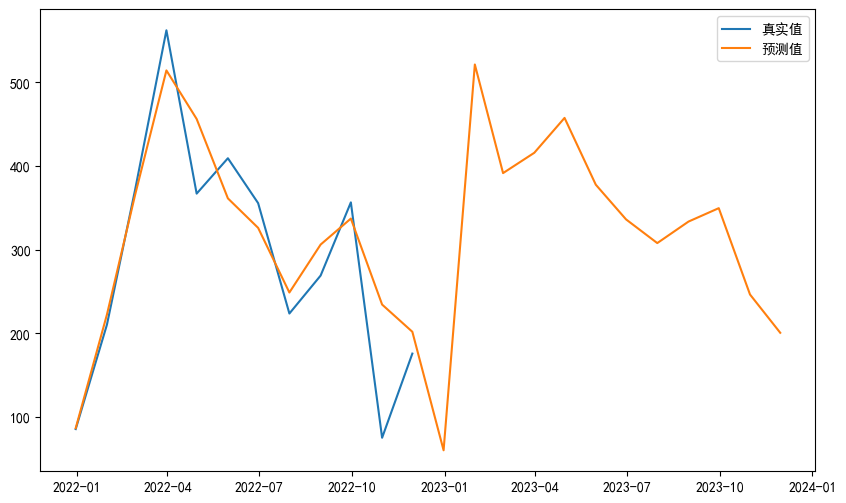

2021-12-31     86.492581
2022-01-31    222.418799
2022-02-28    365.814097
2022-03-31    514.369359
2022-04-30    456.301082
2022-05-31    361.343950
2022-06-30    326.067929
2022-07-31    248.769414
2022-08-31    306.109273
2022-09-30    337.191429
2022-10-31    234.352092
2022-11-30    201.794847
2022-12-31     60.100433
2023-01-31    521.425876
2023-02-28    391.564861
2023-03-31    415.876611
2023-04-30    457.576735
2023-05-31    377.695880
2023-06-30    336.219279
2023-07-31    307.875453
2023-08-31    333.608697
2023-09-30    349.634602
2023-10-31    246.389832
2023-11-30    200.607685
Freq: M, dtype: float64

In [5]:
model = model_predict.load_rnn_model_best(LSTMModel, model_parameters)
model_predict.predict_to_future_rnn(model, series, scaler, last_months=12)